# Performance do Modelo

Além de medir a performance do modelo utilizando métricas estatísticas, vamos tentar analisar a performance do modelo escolhido com métricas que possam ser traduzidas para o negócio.
O modelo escolhido foi a Explainable Boosting Machine. Além de ter performado melhor que os outros modelos, ainda ganhamos mais interpretabilidade. Considerando um modelo de score de crédito, a performance do modelo é esperada (por volta de 70% de ROC e ~30% de KS). A partir do score da resposta do modelo podemos montar um escore de crédito.

* KS de teste = 31.66%
* ROC Teste = ~70%

1. Análise de Feature Importance com a biblioteca Interpret
2. Normalizar os dados para gerar um Score
3. Análise de Bad Rate por decil
4. Análise de Bad Rate Acumulada por Decil
5. Criação de Segmentos baseado no Score 

In [1]:
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
from interpret import show
from galeritas import bar_plot_with_population_proportion
from utils import woe_table

In [2]:
treino_pross = pd.read_parquet('../../data/processed/treino_processado_ebm.parquet')
teste_pross = pd.read_parquet('../../data/processed/teste_processado_ebm.parquet')

raw = pd.read_csv('../../data/raw/base_modelo.csv')

model = joblib.load('../../src/model/models/ebm_model.pkl')

In [3]:
# Vamos mergear apenas a variável target da base bruta para podermos fazer as análises que comentamos acima
treino = treino_pross.reset_index().merge(right=raw[['id', 'y']], how='left', on='id')
teste = teste_pross.reset_index().merge(right=raw[['id', 'y']], how='left', on='id')

## 1. Análise da Importância das Variáveis

In [4]:
# Plotar o dashbooard de explicação da importância das variáveis utilizadas no modelo
show(model.explain_global())

<!-- http://127.0.0.1:7001/5358493008/ -->

## 2. Gerar um Escore de Crédito 

In [19]:
# Vamos puxar o mínimo e o máximo do dataset de treino e de teste
print("Máximo e mínimo de probabilidade do dataset de treino:", treino['pred_proba_ebm'].min(), treino['pred_proba_ebm'].max(),
      "\nMáximo e mínimo de probabilidade do dataset de treino:", teste['pred_proba_ebm'].min(), teste['pred_proba_ebm'].max())

Máximo e mínimo de probabilidade do dataset de treino: 0.034955785591846 0.5546735636100457 
Máximo e mínimo de probabilidade do dataset de treino: 0.03622384283257483 0.5546735636100457


### Observação
Vamos realizar o processo de normalização do escore para a base 1. Para isso iremos colocar como o mínimo e máximo probabilidades que aumentem o intervalo do que foi apresentado acima. Isso nos dará segurança de que ninguém poderá ter algum escore abaixo de 0 e nem acima de 1000 futuramente

In [20]:
# Normalizando os dados para ter um range de 0 a 1
treino['pred_proba_ebm_normalizado'] = (treino['pred_proba_ebm'] - 0.03)/(0.6 - 0.03)
teste['pred_proba_ebm_normalizado'] = (teste['pred_proba_ebm'] - 0.03)/(0.6 - 0.03)

In [21]:
# Vamos subtrarir o número 1 da predição normalizada e depois multiplicar por 1000 para gerar um Escore de CréDeprecationWarning
treino['escore_credito'] = ((1 - treino['pred_proba_ebm_normalizado'])*1000).round(0)
teste['escore_credito'] = ((1 - teste['pred_proba_ebm_normalizado'])*1000).round(0)

## 3. Análise de Taxa de Evento por Decil de Escore

In [8]:
# Vamos fazer a análise de decil com a base de teste, pois assim não teremos o viés do treinamento
teste['decil_escore'] = pd.qcut(teste.escore_credito, q=10, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
teste['decil_escore'] = teste['decil_escore'].astype(str)

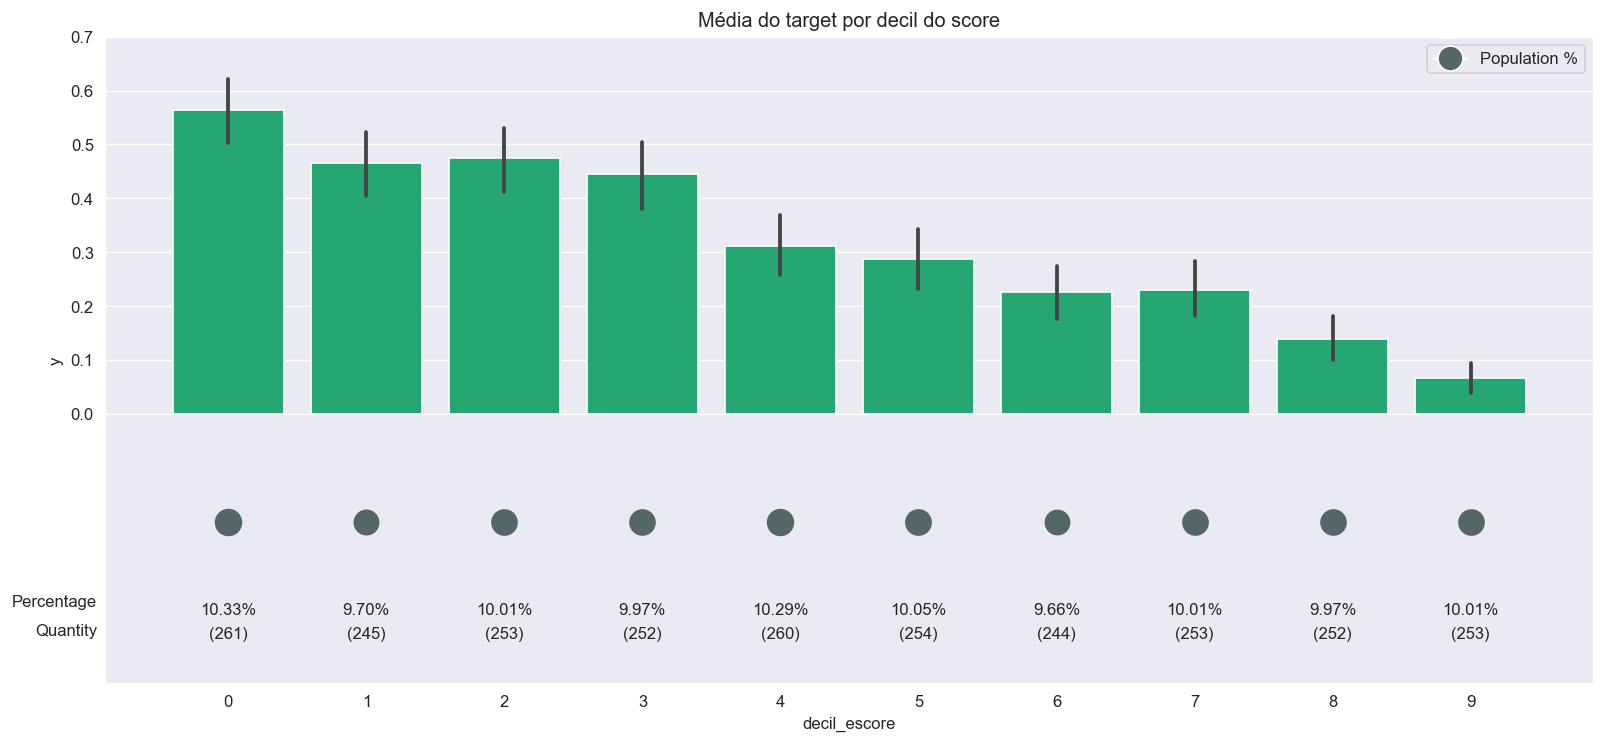

In [9]:
# Vamos utilizar o Bar Plot da EDA para fazer essa análise
bar_plot_with_population_proportion(teste,x='decil_escore', y='y', func=np.mean, plot_title=f'Média do target por decil do score')

### Observações

Conseguimos enxergar que o nosso escore consegue ordenar o risco entre os decis de certa forma, mas há um bom espaço para criar algumas segmentações que podem beneficiar os stakeholders em criar políticas de crédito.

## 4. Análise de Bad Rate Acumulada

Aqui iremos entender quanto capturamos dos eventos de decil em decil. Além de também podermos identificar novos pontos de corte

Text(0, 0.5, 'Proporção')

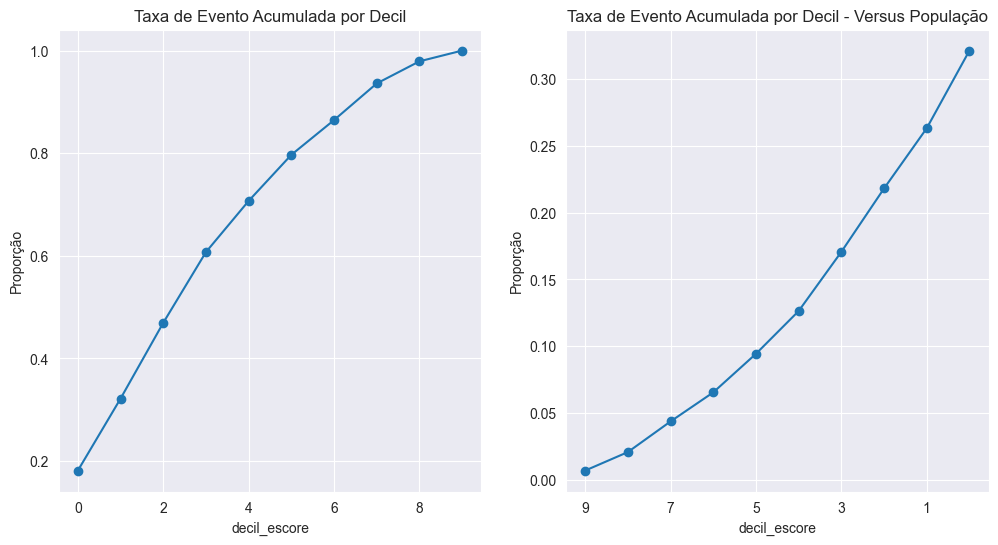

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

(teste.groupby('decil_escore').y.sum().cumsum()/teste.y.sum()).plot(marker='o', ax=axes[0])

axes[0].set_title('Taxa de Evento Acumulada por Decil')
axes[0].set_ylabel('Proporção')

(teste.groupby('decil_escore').y.sum().sort_index(ascending=False).cumsum()/teste.shape[0]).plot(marker='o', ax=axes[1])
                                                                                                 
axes[1].set_title('Taxa de Evento Acumulada por Decil - Versus População')
axes[1].set_ylabel('Proporção')
                                                             

### Observações
* O modelo consegue captar até ~70% de todos os eventos nos primeiros 50% piores decis, o que é um bom indicativo de performance
* Se houver um planejamento de utilizar o modelo como ponto de corte, o segundo gráfico consegue nos dar algum embasamento. Ele mostra a taxa de evento do decil sobre a quantidade de ids de toda a minha amostra. Nesse caso ~33% é a taxa de evento da minha amostra, porém se eu optar por uma política de crédito que barre o pior decil, então eu consigo diminuir a taxa de inadimplência para ~26%, uma diminuição de ~20% na inadimplência.

## 5. Criação de uma Segmentação de Crédito

In [13]:
# Vamos repetir a análise de WoE, já feita anteriormente, para nos auxiliar em criar uma segmentação de créDeprecationWarning
bins = pd.qcut(treino['escore_credito'], q=20, retbins=True, duplicates='drop')[1]

In [14]:
# Aplicando o Peso de Evidência nos bins. Vamos a partir dessas faixas, e com o conhecimento da EDA, propor intervalos novos
cuts = bins
grouped = pd.cut(treino['escore_credito'], cuts)
woe = woe_table(grouped, treino['y'])
woe.sort_index().style.format({
    "count": "{:,.0f}",
    "count_pct": "{:.0%}",
    "bads": "{:,.0f}",
    "goods": "{:,.0f}",
    "bads_pct": "{:.0%}",
    "goods_pct": "{:.0%}",
    "woe": "{:.0%}",
    "diff": "{:.0%}",
    "iv": "{:.1%}",
    "bad_rate": "{:.0%}",
    "bad_rate_norm_avg": "{:.0%}"
})

,count,count_pct,bads,goods,bads_pct,goods_pct,woe,diff,iv,bad_rate,bad_rate_norm_avg
escore_credito,,,,,,,,,,,
"(80.0, 230.0]",400,5%,219,181,10%,3%,113%,6%,7.4%,55%,194%
"(230.0, 301.0]",441,5%,215,226,9%,4%,89%,6%,5.0%,49%,173%
"(301.0, 325.0]",352,4%,153,199,7%,3%,68%,3%,2.2%,43%,154%
"(325.0, 385.0]",451,6%,192,259,8%,4%,64%,4%,2.6%,43%,151%
"(385.0, 413.0]",376,5%,157,219,7%,4%,61%,3%,1.9%,42%,148%
"(413.0, 448.0]",429,5%,148,281,6%,5%,30%,2%,0.5%,34%,122%
"(448.0, 472.0]",409,5%,137,272,6%,5%,26%,1%,0.3%,33%,119%
"(472.0, 515.0]",452,6%,147,305,6%,5%,21%,1%,0.3%,33%,115%
"(515.0, 529.0]",346,4%,107,239,5%,4%,14%,1%,0.1%,31%,110%


In [27]:
cuts = [-np.inf, 301, 413, 529, 740, 872, np.inf]
treino['segmento_credito'] = pd.cut(treino['escore_credito'], cuts)
woe = woe_table(treino['segmento_credito'], treino['y'])
woe.sort_index().style.format({
    "count": "{:,.0f}",
    "count_pct": "{:.0%}",
    "bads": "{:,.0f}",
    "goods": "{:,.0f}",
    "bads_pct": "{:.0%}",
    "goods_pct": "{:.0%}",
    "woe": "{:.0%}",
    "diff": "{:.0%}",
    "iv": "{:.1%}",
    "bad_rate": "{:.0%}",
    "bad_rate_norm_avg": "{:.0%}"
})

,count,count_pct,bads,goods,bads_pct,goods_pct,woe,diff,iv,bad_rate,bad_rate_norm_avg
segmento_credito,,,,,,,,,,,
"(-inf, 301.0]",881,11%,460,421,20%,7%,102%,13%,13.0%,52%,185%
"(301.0, 413.0]","1,179",14%,502,677,22%,11%,64%,10%,6.5%,43%,151%
"(413.0, 529.0]","1,636",20%,539,"1,097",23%,19%,22%,5%,1.0%,33%,117%
"(529.0, 740.0]","2,881",35%,654,"2,227",28%,38%,-29%,-10%,2.8%,23%,80%
"(740.0, 872.0]","1,231",15%,142,"1,089",6%,18%,-110%,-12%,13.6%,12%,41%
"(872.0, inf]",403,5%,19,384,1%,7%,-207%,-6%,11.8%,5%,17%


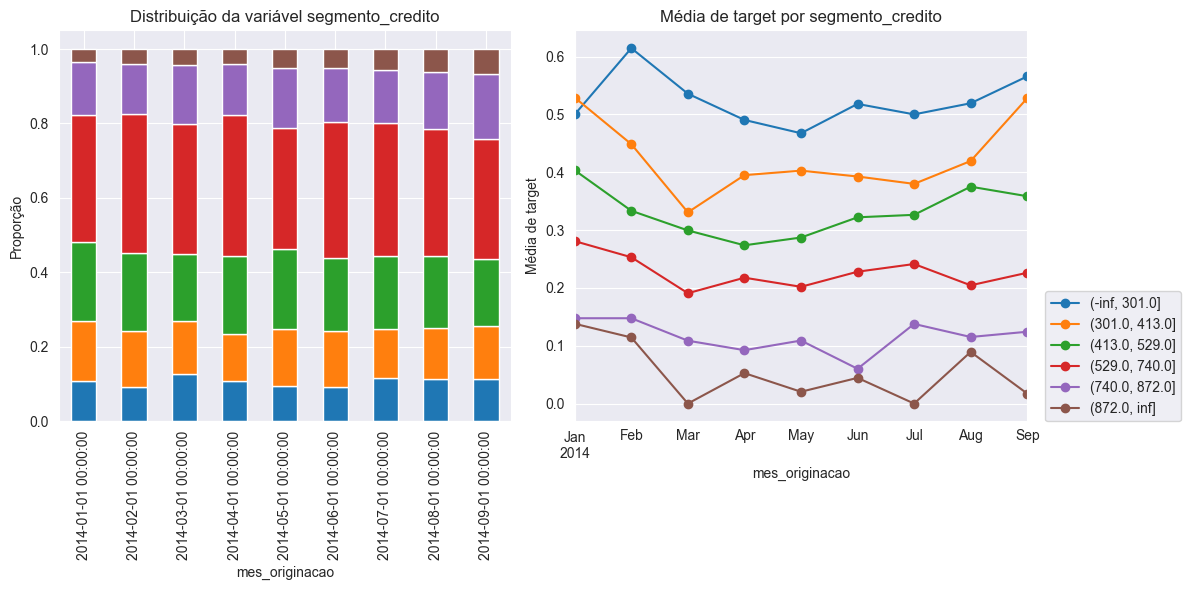

In [28]:
# Criando a figura e os eixos para os subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

treino.groupby('mes_originacao').segmento_credito.value_counts(normalize=True).unstack().plot(
    kind='bar', stacked=True, ax=axes[0], legend=False
)
axes[0].set_title('Distribuição da variável segmento_credito')
axes[0].set_ylabel('Proporção')

# Segundo gráfico: Gráfico de linha
treino.groupby(['mes_originacao', 'segmento_credito']).y.mean().unstack().plot(
    ax=axes[1], marker='o', linestyle='-'
)
plt.legend(loc=(1.04,0))
axes[1].set_title('Média de target por segmento_credito')
axes[1].set_ylabel('Média de target')

# Ajustar espaçamento entre os subplots
plt.tight_layout()

# Exibir os gráficos
plt.show()


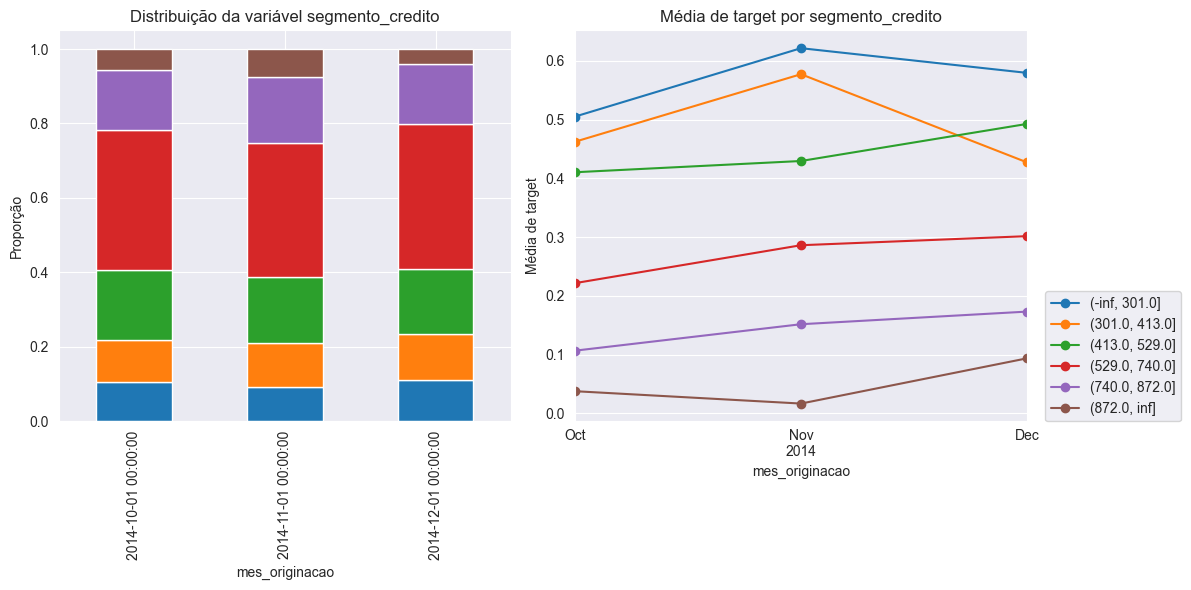

In [29]:
# Vamos aplicar a mesma faixa de escore e entender se a segmentação se mantém estável no dataset de teste
teste['segmento_credito'] = pd.cut(teste.escore_credito, cuts)

# Criando a figura e os eixos para os subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

teste.groupby('mes_originacao').segmento_credito.value_counts(normalize=True).unstack().plot(
    kind='bar', stacked=True, ax=axes[0], legend=False
)
axes[0].set_title('Distribuição da variável segmento_credito')
axes[0].set_ylabel('Proporção')

# Segundo gráfico: Gráfico de linha
teste.groupby(['mes_originacao', 'segmento_credito']).y.mean().unstack().plot(
    ax=axes[1], marker='o', linestyle='-'
)
plt.legend(loc=(1.04,0))
axes[1].set_title('Média de target por segmento_credito')
axes[1].set_ylabel('Média de target')

# Ajustar espaçamento entre os subplots
plt.tight_layout()

# Exibir os gráficos
plt.show()


# Conclusão
* O modelo entregue possui uma performance que está dentro da performance esperada para modelos que tentam predizer a inadimplência. Além disso, a partir dele conseguimos entregar um escore de crédito que se mostrou estável nas safras, com salvo exceção ao segmento de 301 até 413, porém precisaríamos de mais safras para garantir a estabilidade real desse modelo;
* Com as ressalvas ditas, o modelo se mostrou eficiente para nortear com qualidade uma boa análise de crédito da base, podendo servir de apoio para a criação de políticas de preço e de crédito. 
* Importante ressaltar que há um espaço bom de melhorias para o modelo. Infelizmente não tivemos acesso a bases de bureaus externas que em versões futuras podem servir para torná-lo cada vez mais robusto